In [1]:
import uproot
from glob import glob
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
from coffea.analysis_tools import PackedSelection


mplhep.style.use(mplhep.style.CMS)
#SWAN 
base_directory = "/eos/user/d/dgrove/datasets/"

# sort Monte Carlo files here
files = sorted(glob(f"{base_directory}ttbar_nAODv9/combined.root"))

file = uproot.open(files[0])
print("Example file info:")
dict(file)

Example file info:


{'tag;3': <TObjString 'untagged' at 0x7f6075f7b190>,
 'tag;2': <TObjString 'untagged' at 0x7f6075f7b270>,
 'tag;1': <TObjString 'untagged' at 0x7f6075f7b350>,
 'Events;1': <TTree 'Events' (1666 branches) at 0x7f6075f6b700>,
 'LuminosityBlocks;1': <TTree 'LuminosityBlocks' (2 branches) at 0x7f6075f6b7c0>,
 'Runs;1': <TTree 'Runs' (8 branches) at 0x7f6075f6b550>,
 'MetaData;1': <TTree 'MetaData' (1 branches) at 0x7f6075f6b3d0>,
 'ParameterSets;1': <TTree 'ParameterSets' (1 branches) at 0x7f5f282fa970>}

In [2]:
events = NanoEventsFactory.from_root(files[0]).events()
len(events)

/eos/user/d/dgrove/.local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:205: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/eos/user/d/dgrove/.local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:205: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


1721808

In [3]:
selection = PackedSelection()

selection.add("e pt", ak.any(events.Electron.pt >= 5, axis=1))
selection.add("e eta", ak.any(np.abs(events.Electron.eta) < 2.4, axis=1))
selection.add("e SIP3D", ak.any(events.Electron.sip3d < 8, axis=1))
selection.add("e dxy", ak.any(np.abs(events.Electron.dxy) < 0.05, axis=1))
selection.add("e dz", ak.any(np.abs(events.Electron.dz) < 0.1, axis=1))
selection.add("e miniPFRelIso", ak.any(events.Electron.miniPFRelIso_all < (20 + 300/events.Electron.pt), axis =1))

selection.add("mu pt", ak.any(events.Muon.pt >= 3, axis=1))
selection.add("mu eta", ak.any(np.abs(events.Muon.eta) < 2.4, axis=1))
selection.add("mu SIP3D", ak.any(events.Muon.sip3d < 8, axis=1))
selection.add("mu dxy", ak.any(np.abs(events.Muon.dxy) < 0.05, axis=1))
selection.add("mu dz", ak.any(np.abs(events.Muon.dz) < 0.1, axis=1))
selection.add("mu miniPFRelIso", ak.any(events.Muon.miniPFRelIso_all < (20 + 300/events.Muon.pt), axis=1))

# individual cuts above, all in one selection cuts below:
# please use cuts below if doing preselection cut lest you run into some logical bugs down the road

selection.add("e selection", ak.any((events.Electron.pt >= 5) & (np.abs(events.Electron.eta) < 2.4) & (events.Electron.sip3d < 8) & (np.abs(events.Electron.dxy) < 0.05) & (np.abs(events.Electron.dz) < 0.1) & (events.Electron.miniPFRelIso_all < (20 + 300/events.Electron.pt)), axis=1))

selection.add("mu selection", ak.any((events.Muon.pt >= 5) & (np.abs(events.Muon.eta) < 2.4) & (events.Muon.sip3d < 8) & (np.abs(events.Muon.dxy) < 0.05) & (np.abs(events.Muon.dz) < 0.1) & (events.Muon.miniPFRelIso_all < (20 + 300/events.Muon.pt)), axis=1))


In [4]:
selected_events = events[selection.all("e selection", "mu selection")]
print(len(events))
print(len(selected_events))

1721808
608378


In [5]:
# Step 1: Grab low pt electron collection from our events
lpt_e = events.LowPtElectron

# Step 2: Initialize PackedSelection
LowPtElectron_selection = PackedSelection()

# Step 3: Create a mask for events containing at least one low pt electron that meets the criteria
LowPtElectron_selection.add("lpt_e selection", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1), axis=1))
LowPtElectron_selection.add("lpt_e pt", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1), axis=1))

# Step 4: Apply the event-level selection mask to the events and extract the low pt electrons
selected_events = events[LowPtElectron_selection.all("lpt_e selection")]
print(f"number of events before cuts: {len(events)}")

print(f"number of events with at least one passing lowpte: {len(selected_events)}")
print(f"number of events after pt cut: {len(events[LowPtElectron_selection.all('lpt_e pt')])}")

# Step 5: Now, filter the low pt electrons within those selected events to include only those that pass the criteria
selected_lpt_e = selected_events.LowPtElectron[(selected_events.LowPtElectron.pt <= 5) & (selected_events.LowPtElectron.pt > 1) & (selected_events.LowPtElectron.genPartFlav == 1)]

# Step 6: Count the number of selected electrons
print(f"number of LowPtElectrons across all events that pass: {np.sum(ak.num(selected_lpt_e))}")


number of events before cuts: 1721808
number of events with at least one passing lowpte: 12475
number of events after pt cut: 519705
number of LowPtElectrons across all events that pass: 12767


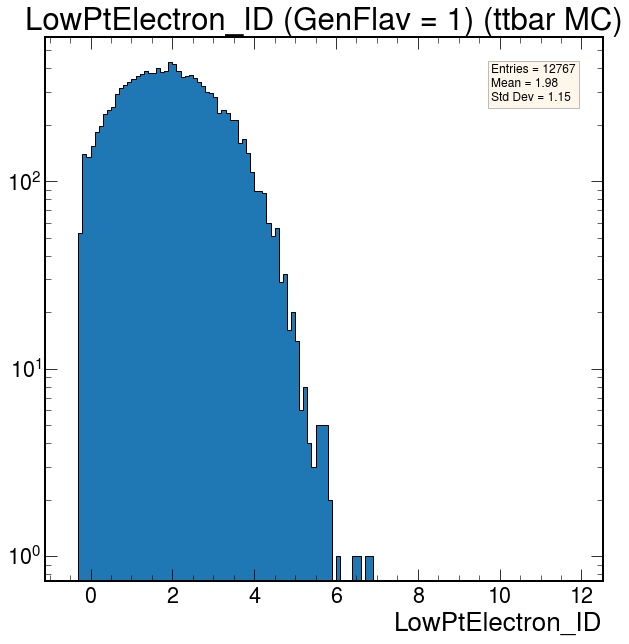

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_ID")
ax.set_title("LowPtElectron_ID (GenFlav = 1) (ttbar MC)")
ax.set_yscale('log')
flattened_IDs = ak.flatten(selected_lpt_e.ID)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 12, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_IDs, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

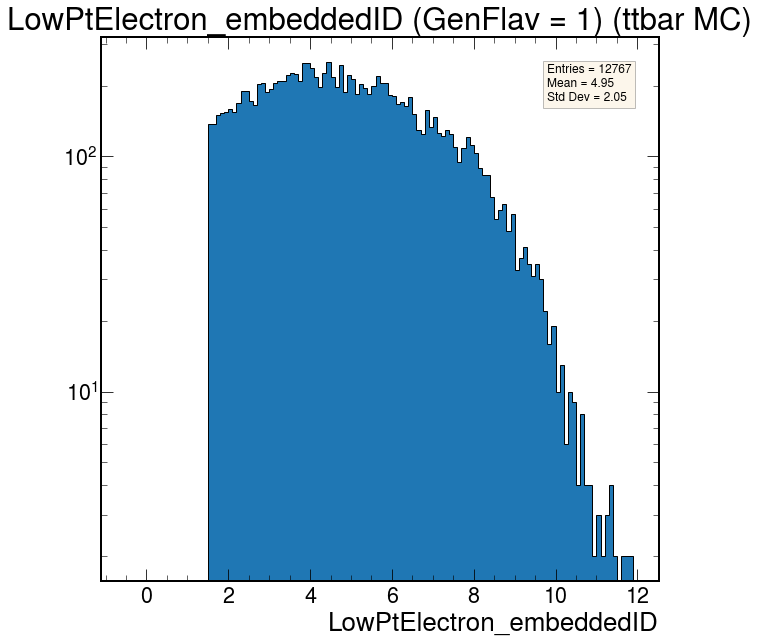

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_embeddedID")
ax.set_title("LowPtElectron_embeddedID (GenFlav = 1) (ttbar MC)")
ax.set_yscale('log')
flattened_IDs = ak.flatten(selected_lpt_e.embeddedID)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 12, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_IDs, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

In [8]:
events.LowPtElectron.fields

['ID',
 'convVtxRadius',
 'deltaEtaSC',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eInvMinusPInv',
 'embeddedID',
 'energyErr',
 'eta',
 'hoe',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'phi',
 'pt',
 'ptbiased',
 'r9',
 'scEtOverPt',
 'sieie',
 'unbiased',
 'charge',
 'convWP',
 'pdgId',
 'convVeto',
 'lostHits',
 'genPartIdx',
 'genPartFlav',
 'genPartIdxG']

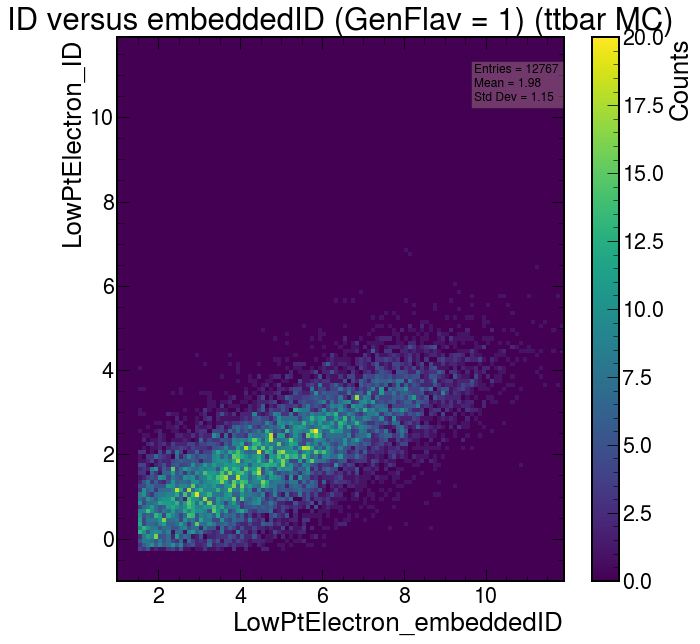

In [29]:
# Flatten the jagged arrays into 1D arrays
flattened_eIDs = ak.flatten(selected_lpt_e.embeddedID)
flattened_IDs = ak.flatten(selected_lpt_e.ID)

# Plotting
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_embeddedID")
ax.set_ylabel("LowPtElectron_ID")
ax.set_title("ID versus embeddedID (GenFlav = 1) (ttbar MC)")

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------

# 2D Histogram
h2d = ax.hist2d(flattened_eIDs, flattened_IDs, bins=[np.arange(1, 12, 0.1), np.arange(-1, 12, 0.1)], cmap='viridis')

# Adding a colorbar
cbar = plt.colorbar(h2d[3], ax=ax)
cbar.set_label('Counts')
#ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

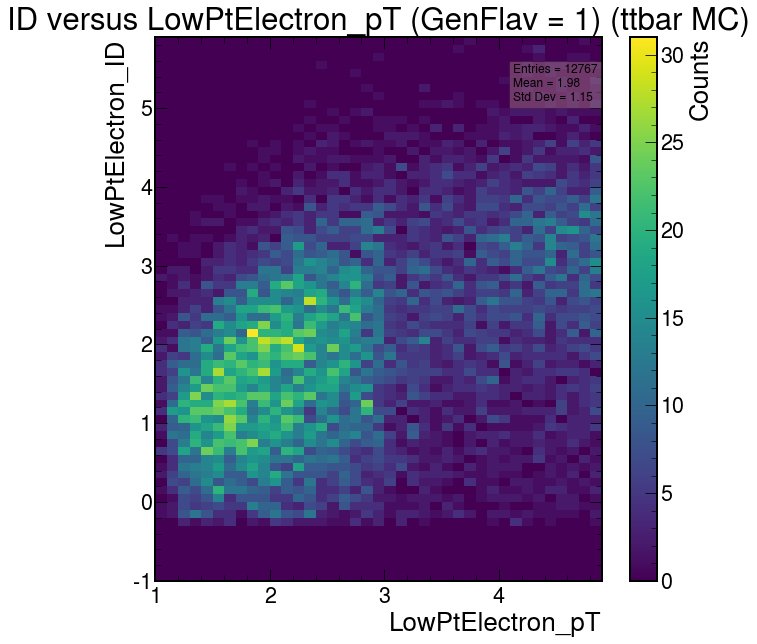

In [30]:
# Flatten the jagged arrays into 1D arrays
flattened_eIDs = ak.flatten(selected_lpt_e.embeddedID)
flattened_IDs = ak.flatten(selected_lpt_e.ID)

# Plotting
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_pT")
ax.set_ylabel("LowPtElectron_ID")
ax.set_title("ID versus LowPtElectron_pT (GenFlav = 1) (ttbar MC)")

# 2D Histogram
h2d = ax.hist2d(ak.flatten(selected_lpt_e.pt), flattened_IDs, bins=[np.arange(1, 5, 0.1), np.arange(-1, 6, 0.1)], cmap='viridis')

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------
# Adding a colorbar
cbar = plt.colorbar(h2d[3], ax=ax)
cbar.set_label('Counts')
#ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

# GenFlav = 0 plots below

In [11]:
# Step 1: Grab low pt electron collection from our selected events at mass points 300 and 275
#lpt_e = selectron_L_300_LSP_275_events.LowPtElectron

# Step 2: Create a mask for the low pt electrons that meet the criteria
electron_mask_flav0 = (lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0)

# Step 3: Create a mask at the event level to select events that contain at least one low pt electron passing the criteria
event_mask_flav0 = ak.any(electron_mask_flav0, axis=1)

# Step 4: Apply the event-level mask to the events and extract the low pt electrons
selected_events_flav0 = events[event_mask_flav0]

# Step 5: Now, filter the low pt electrons within those selected events to include only those that pass the criteria
selected_lpt_e_flav0 = selected_events_flav0.LowPtElectron[electron_mask_flav0[event_mask_flav0]]

# Step 6: Count the number of selected electrons
print(np.sum(ak.num(selected_lpt_e_flav0)))
print(len(selected_events_flav0))

495024
424906


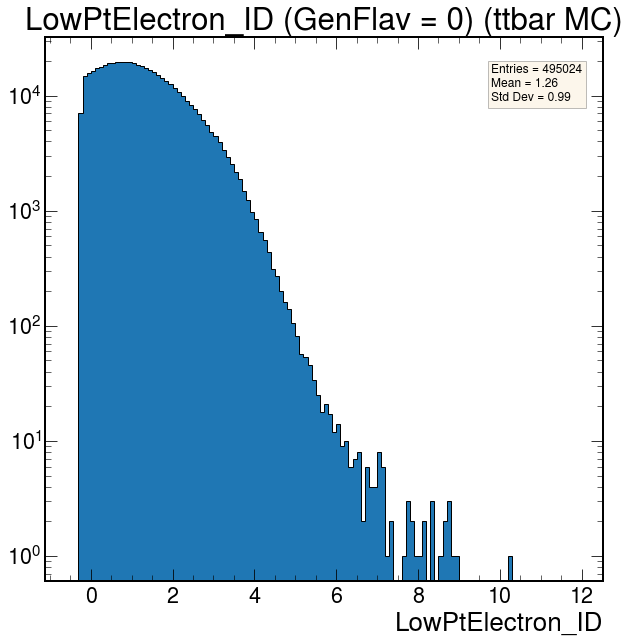

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_ID")
ax.set_title("LowPtElectron_ID (GenFlav = 0) (ttbar MC)")
ax.set_yscale('log')
flattened_IDs = ak.flatten(selected_lpt_e_flav0.ID)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 12, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_IDs, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

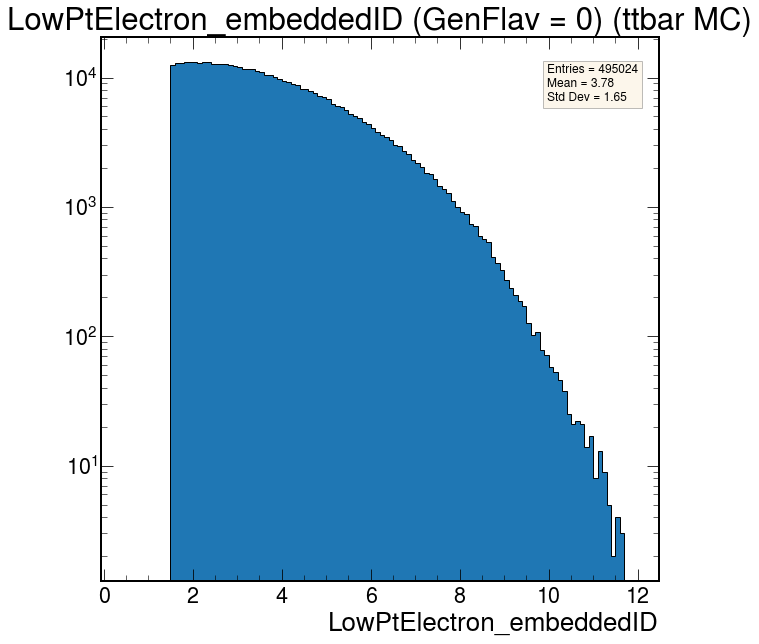

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_embeddedID")
ax.set_title("LowPtElectron_embeddedID (GenFlav = 0) (ttbar MC)")
ax.set_yscale('log')
flattened_eIDs = ak.flatten(selected_lpt_e_flav0.embeddedID)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_eIDs)
std_dev = np.std(flattened_eIDs)
entries = len(flattened_eIDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.8, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(0.5, 12, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_eIDs, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

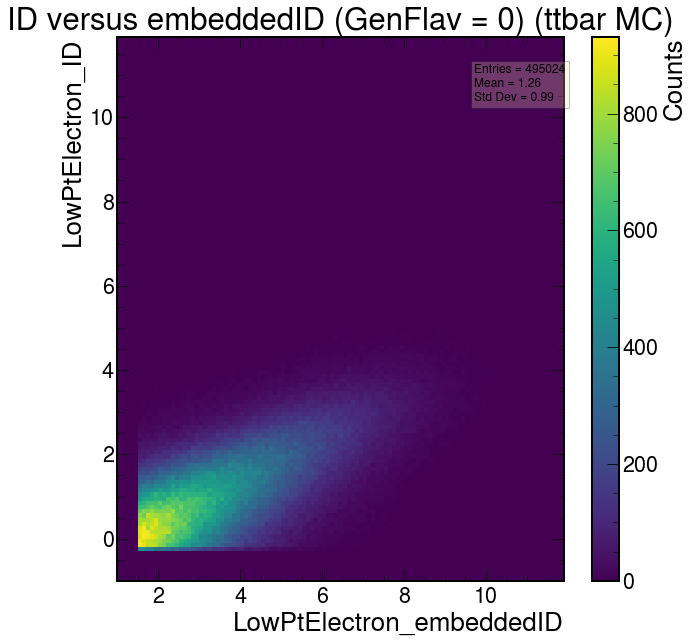

In [33]:
# Flatten the jagged arrays into 1D arrays
flattened_eIDs = ak.flatten(selected_lpt_e_flav0.embeddedID)
flattened_IDs = ak.flatten(selected_lpt_e_flav0.ID)

# Plotting
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_embeddedID")
ax.set_ylabel("LowPtElectron_ID")
ax.set_title("ID versus embeddedID (GenFlav = 0) (ttbar MC)")

# 2D Histogram
h2d = ax.hist2d(flattened_eIDs, flattened_IDs, bins=[np.arange(1, 12, 0.1), np.arange(-1, 12, 0.1)], cmap='viridis')
#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------
# Adding a colorbar
cbar = plt.colorbar(h2d[3], ax=ax)
cbar.set_label('Counts')
#ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

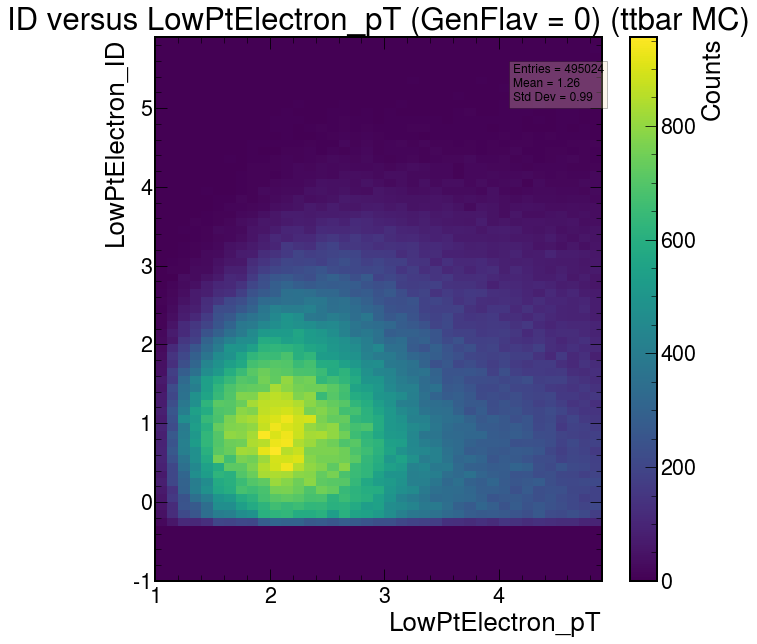

In [34]:
# Flatten the jagged arrays into 1D arrays
flattened_eIDs = ak.flatten(selected_lpt_e_flav0.embeddedID)
flattened_IDs = ak.flatten(selected_lpt_e_flav0.ID)

# Plotting
fig, ax = plt.subplots()
ax.set_xlabel("LowPtElectron_pT")
ax.set_ylabel("LowPtElectron_ID")
ax.set_title("ID versus LowPtElectron_pT (GenFlav = 0) (ttbar MC)")

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_IDs)
std_dev = np.std(flattened_IDs)
entries = len(flattened_IDs)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------

# 2D Histogram
h2d = ax.hist2d(ak.flatten(selected_lpt_e_flav0.pt), flattened_IDs, bins=[np.arange(1, 5, 0.1), np.arange(-1, 6, 0.1)], cmap='viridis')

# Adding a colorbar
cbar = plt.colorbar(h2d[3], ax=ax)
cbar.set_label('Counts')
#ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

In [15]:

LowPtElectron_selection.add("lpt_e selection_flav1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1), axis=1))

LowPtElectron_selection.add("lpt_e selection_flav1_ID1.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.0), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.1), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.2", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.2), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.3", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.3), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.4", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.4), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.5", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.5), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.6", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.6), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.7", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.7), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.8", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.8), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID1.9", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 1.9), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1_ID2.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.ID >= 2.0), axis=1))


In [16]:

LowPtElectron_selection.add("lpt_e selection_flav0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1), axis=1))


LowPtElectron_selection.add("lpt_e selection_flav0_ID1.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.0), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.1), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.2", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.2), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.3", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.3), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.4", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.4), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.5", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.5), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.6", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.6), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.7", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.7), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.8", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.8), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID1.9", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 1.9), axis=1))
LowPtElectron_selection.add("lpt_e selection_flav0_ID2.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.ID >= 2.0), axis=1))


In [17]:
print("ttbar")
print(len(events[LowPtElectron_selection.all("lpt_e selection_flav1")]))
print(f"event count with ID >= 1.0: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.0')])}")
print(f"event count with ID >= 1.1: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.1')])}")
print(f"event count with ID >= 1.2: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.2')])}")
print(f"event count with ID >= 1.3: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.3')])}")
print(f"event count with ID >= 1.4: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.4')])}")
print(f"event count with ID >= 1.5: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.5')])}")
print(f"event count with ID >= 1.6: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.6')])}")
print(f"event count with ID >= 1.7: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.7')])}")
print(f"event count with ID >= 1.8: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.8')])}")
print(f"event count with ID >= 1.9: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID1.9')])}")
print(f"event count with ID >= 2.0: {len(events[LowPtElectron_selection.all('lpt_e selection_flav1_ID2.0')])}")

ttbar
12475
event count with ID >= 1.0: 9739
event count with ID >= 1.1: 9396
event count with ID >= 1.2: 9050
event count with ID >= 1.3: 8685
event count with ID >= 1.4: 8314
event count with ID >= 1.5: 7949
event count with ID >= 1.6: 7583
event count with ID >= 1.7: 7193
event count with ID >= 1.8: 6818
event count with ID >= 1.9: 6436
event count with ID >= 2.0: 6017


In [20]:
lpte_selection_eID_flav1 = PackedSelection()

lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.0), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.1), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.2", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.2), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.3", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.3), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.4", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.4), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.5", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.5), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.6", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.6), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.7", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.7), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.8", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.8), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID4.9", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 4.9), axis=1))
lpte_selection_eID_flav1.add("lpt_e selection_flav1_eID5.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 1) & (lpt_e.embeddedID >= 5.0), axis=1))


In [21]:
print("ttbar")
print(f"event count with embeddedID >= 4.0: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.0')])}")
print(f"event count with embeddedID >= 4.1: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.1')])}")
print(f"event count with embeddedID >= 4.2: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.2')])}")
print(f"event count with embeddedID >= 4.3: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.3')])}")
print(f"event count with embeddedID >= 4.4: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.4')])}")
print(f"event count with embeddedID >= 4.5: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.5')])}")
print(f"event count with embeddedID >= 4.6: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.6')])}")
print(f"event count with embeddedID >= 4.7: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.7')])}")
print(f"event count with embeddedID >= 4.8: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.8')])}")
print(f"event count with embeddedID >= 4.9: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID4.9')])}")
print(f"event count with embeddedID >= 5.0: {len(events[lpte_selection_eID_flav1.all('lpt_e selection_flav1_eID5.0')])}")

ttbar
event count with embeddedID >= 4.0: 7908
event count with embeddedID >= 4.1: 7675
event count with embeddedID >= 4.2: 7465
event count with embeddedID >= 4.3: 7274
event count with embeddedID >= 4.4: 7057
event count with embeddedID >= 4.5: 6812
event count with embeddedID >= 4.6: 6603
event count with embeddedID >= 4.7: 6413
event count with embeddedID >= 4.8: 6175
event count with embeddedID >= 4.9: 5989
event count with embeddedID >= 5.0: 5775


In [35]:
print("ttbar")
print(len(events[LowPtElectron_selection.all("lpt_e selection_flav0")]))
print(f"event count with ID >= 1.0: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.0')])}")
print(f"event count with ID >= 1.1: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.1')])}")
print(f"event count with ID >= 1.2: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.2')])}")
print(f"event count with ID >= 1.3: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.3')])}")
print(f"event count with ID >= 1.4: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.4')])}")
print(f"event count with ID >= 1.5: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.5')])}")
print(f"event count with ID >= 1.6: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.6')])}")
print(f"event count with ID >= 1.7: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.7')])}")
print(f"event count with ID >= 1.8: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.8')])}")
print(f"event count with ID >= 1.9: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID1.9')])}")
print(f"event count with ID >= 2.0: {len(events[LowPtElectron_selection.all('lpt_e selection_flav0_ID2.0')])}")

ttbar
424906
event count with ID >= 1.0: 248465
event count with ID >= 1.1: 232108
event count with ID >= 1.2: 216242
event count with ID >= 1.3: 200634
event count with ID >= 1.4: 185316
event count with ID >= 1.5: 170510
event count with ID >= 1.6: 156025
event count with ID >= 1.7: 142336
event count with ID >= 1.8: 129402
event count with ID >= 1.9: 117157
event count with ID >= 2.0: 105394


In [37]:
lpte_selection_eID_flav0 = PackedSelection()

lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.0), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.1", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.1), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.2", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.2), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.3", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.3), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.4", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.4), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.5", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.5), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.6", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.6), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.7", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.7), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.8", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.8), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID4.9", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 4.9), axis=1))
lpte_selection_eID_flav0.add("lpt_e selection_flav0_eID5.0", ak.any((lpt_e.pt <= 5) & (lpt_e.pt > 1) & (lpt_e.genPartFlav == 0) & (lpt_e.embeddedID >= 5.0), axis=1))


In [38]:
print("ttbar")
print(f"event count with embeddedID >= 4.0: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.0')])}")
print(f"event count with embeddedID >= 4.1: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.1')])}")
print(f"event count with embeddedID >= 4.2: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.2')])}")
print(f"event count with embeddedID >= 4.3: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.3')])}")
print(f"event count with embeddedID >= 4.4: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.4')])}")
print(f"event count with embeddedID >= 4.5: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.5')])}")
print(f"event count with embeddedID >= 4.6: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.6')])}")
print(f"event count with embeddedID >= 4.7: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.7')])}")
print(f"event count with embeddedID >= 4.8: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.8')])}")
print(f"event count with embeddedID >= 4.9: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID4.9')])}")
print(f"event count with embeddedID >= 5.0: {len(events[lpte_selection_eID_flav0.all('lpt_e selection_flav0_eID5.0')])}")

ttbar
event count with embeddedID >= 4.0: 180500
event count with embeddedID >= 4.1: 172118
event count with embeddedID >= 4.2: 163904
event count with embeddedID >= 4.3: 155921
event count with embeddedID >= 4.4: 148052
event count with embeddedID >= 4.5: 140598
event count with embeddedID >= 4.6: 133139
event count with embeddedID >= 4.7: 126019
event count with embeddedID >= 4.8: 119016
event count with embeddedID >= 4.9: 112406
event count with embeddedID >= 5.0: 105890


In [ ]:
new_selection = PackedSelection()

selection.add("lpt_e mega selection", ak.any((events.LowPtElectron.genPartFlav == 1) & (events.LowPtElectron.pt < 1) & (events.LowPtElectron.pt <= 5) & (np.abs(events.LowPtElectron.eta) < 2.4) & (np.abs(events.LowPtElectron.dxy) < 0.05) & (np.abs(events.LowPtElectron.dz) < 0.1) & (events.LowPtElectron.miniPFRelIso_all < (20 + 300/events.LowPtElectron.pt)), axis=1))


In [ ]:
lpt_sel_events = events[selection.all("lpt_e mega selection")]
print(len(lpt_sel_events))

In [ ]:
new_selection.add("lpt_e mega selection", ak.any((events.LowPtElectron.genPartFlav == 1) & (events.LowPtElectron.pt >= 1) & (events.LowPtElectron.pt < 5), axis=1))


In [ ]:
lpt_sel_events = events[new_selection.all("lpt_e mega selection")]
print(len(lpt_sel_events))

In [ ]:
events.Electron.fields